In [1]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

In [2]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [5]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,group
0,TM_P1911_190,2
1,TM_P1912_030,2
2,TM_P1912_032,2
3,TM_P1912_033,2
4,TM_P1912_034,2
...,...,...
192,TM_M2012_138,1
193,TM_M2012_046,1
194,TM_M2012_129,1
195,TM_M2012_128,1


In [6]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [7]:
qm = (

    QuantMatrix(
        quantification_file="../tests/input_files/data_sepsis.tsv",
        design_matrix_file=design_matrix
    )
    .filter()
    .normalize(method="mean", use_rt_sliding_window_filter=True, rt_unit="second", stride=5, minimum_data_points=200)
    .quantify(method="top_n", top_n=5, summarization_method="mean").impute(method="neighborhood")
    .annotate()
).to_df()

# IGKV3-20
# IGHV3-30
# IGKV1-39
# IGKV1-17
# IGLV3-25

# qm = qm[~qm['Gene'].str.contains("IGKV")]
# qm = qm[~qm['Gene'].str.contains("IGHV")]
# qm = qm[~qm['Gene'].str.contains("IGLV")]

/Users/aaron/Documents/projects/dpks/DPKS/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [8]:
qm = (

    QuantMatrix(
        quantification_file=qm,
        design_matrix_file=design_matrix
    )
    .compare(method="linregress", min_samples_per_group=10, comparisons=[(2, 1)])
    .cluster(q_value=0.1)
)

<Axes: xlabel='distance_score', ylabel='Count'>

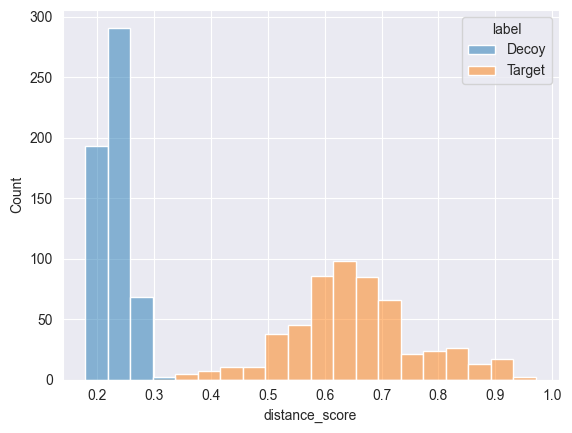

In [9]:
sns.histplot(qm.clusterer.distance_df, x="distance_score", hue="label", bins=20)

In [10]:
qm.row_annotations.sort_values("FeatureCluster")

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
8,P02787,TF,0.114378,29.080894,29.235061,0.498493,0.448078,-0.154166,3.112043e-02,123,74,2.483154e-02,1.604996,1
39,Q04756,HGFAC,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,5.847756e-06,5.233011,1
40,P02768,ALB,0.024260,32.911592,32.883534,0.230820,0.241586,0.028058,4.202495e-01,123,74,2.221701e-01,0.653314,1
344,P02786,TFRC,0.274371,18.213893,18.648340,1.087874,0.857236,-0.434448,3.957148e-03,123,74,4.192893e-03,2.377486,1
9,P00738,HP,0.069402,30.383598,30.264077,1.583586,1.104578,0.119521,5.705962e-01,123,74,2.847264e-01,0.545572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,P61769,B2M,1.076449,22.823686,21.643795,0.733103,0.974937,1.179891,4.413086e-18,123,74,1.373573e-16,15.862148,129
524,P04206,IGKV3-20,0.483930,20.836447,20.325710,0.592031,0.552182,0.510737,1.036226e-08,123,74,4.448624e-08,7.351774,130
204,P41222,PTGDS,0.589965,20.108852,19.354449,0.756752,0.944021,0.754403,4.742012e-09,123,74,2.186595e-08,7.660232,130
423,P36222,CHI3L1,0.769862,19.807596,18.697789,1.363901,0.734480,1.109807,9.818212e-10,123,74,4.989255e-09,8.301964,130


In [11]:
qm.clusterer.distance_cutoff

0.7387717431227221

In [12]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

dist_linkage = hierarchy.linkage(
    squareform(qm.clusterer.target_distance_matrix),
    method="ward"
)

/Users/aaron/miniconda3/envs/DPKS-3.12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:3414: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ivl.append(labels[int(i - n)])


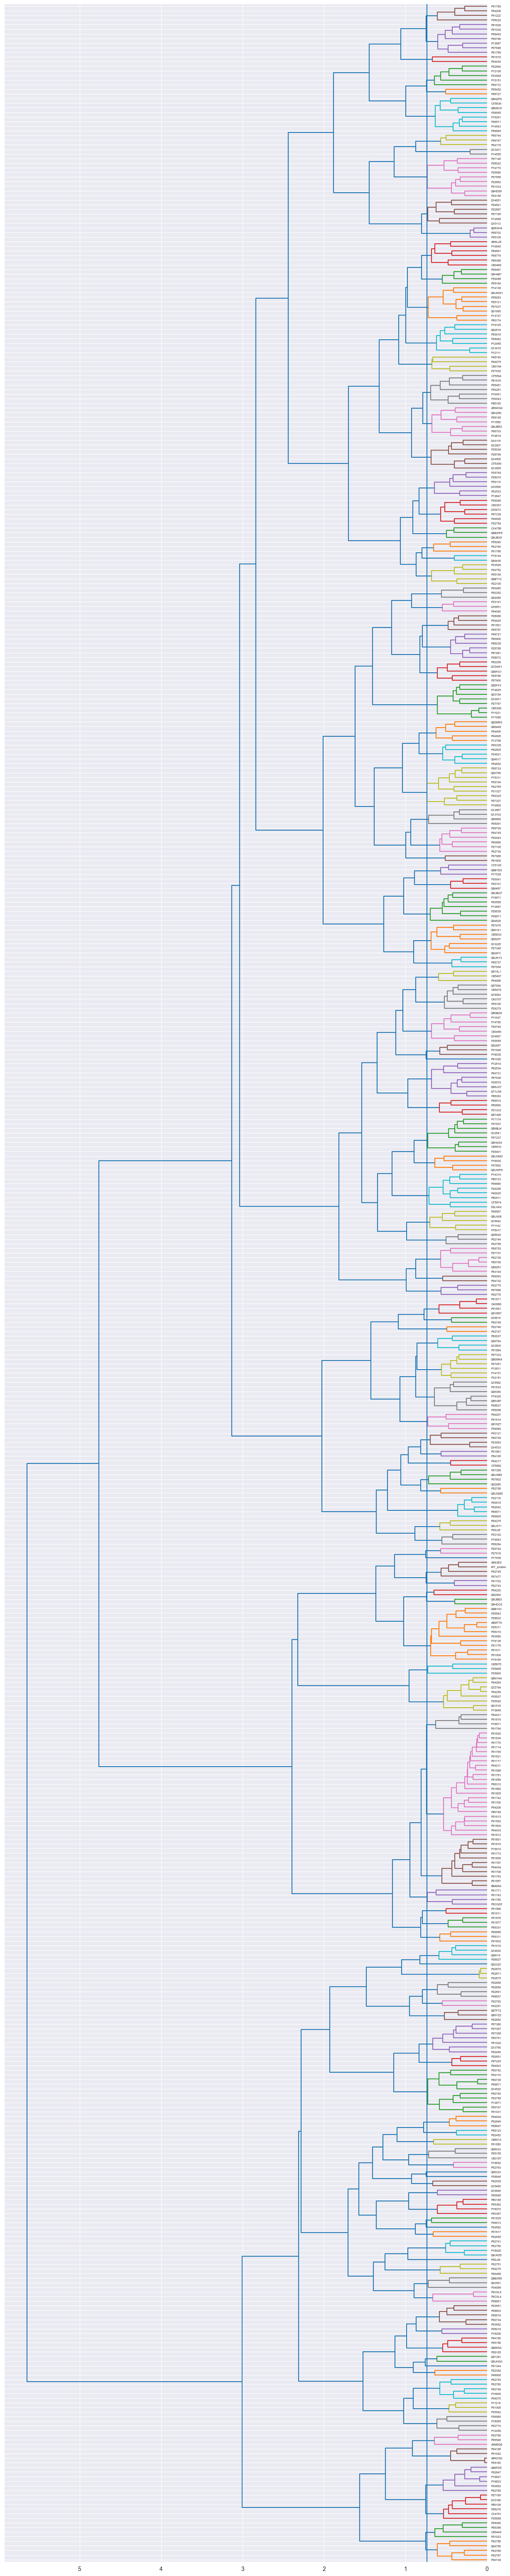

In [13]:
import matplotlib.pyplot as plt

plt.figure()

dn = hierarchy.dendrogram(dist_linkage,
                          orientation="left",
                          color_threshold=qm.clusterer.distance_cutoff,
                          labels=qm.row_annotations['Protein'])

plt.gca().axvline(x=qm.clusterer.distance_cutoff)

plt.gcf().set_size_inches(15, 80)

In [14]:
feature_clusters_df = qm.to_df()

In [16]:
len(feature_clusters_df['FeatureCluster'].unique())

130

In [93]:
feature_clusters_df

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,...,TM_M2012_143,TM_M2012_127,TM_M2012_142,TM_M2012_141,TM_M2012_140,TM_M2012_138,TM_M2012_046,TM_M2012_129,TM_M2012_128,TM_M2012_041
0,P08603,CFH,0.025773,26.006091,25.966725,0.433367,0.464303,0.039366,5.505849e-01,123,...,25.802487,26.105042,26.420250,26.221081,26.340885,26.506286,25.554557,25.882230,26.127273,25.349951
1,P02671,FGA,0.033026,29.690567,29.636712,0.583305,0.716461,0.053855,5.679056e-01,123,...,28.853414,30.149257,29.197804,28.621154,28.755807,28.714631,30.152004,29.687418,29.690871,29.899585
2,P01042,KNG1,0.052594,25.766212,25.691213,0.404983,0.457798,0.075000,2.348067e-01,123,...,25.641637,25.976786,26.006295,26.419994,26.266191,26.235283,25.855960,25.698188,25.819909,25.014092
3,P00450,CP,0.106411,27.060110,26.924670,0.397618,0.458254,0.135441,3.094964e-02,123,...,25.741675,26.431833,26.806068,26.530103,26.332136,26.458858,26.972161,26.218911,26.516520,26.899652
4,P05156,CFI,0.061511,23.398218,23.301886,0.638981,0.503637,0.096332,2.723188e-01,123,...,21.955532,23.697400,22.644218,22.945791,22.847406,23.612404,23.536738,23.176269,23.637924,22.685965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,CSF1R,0.760640,19.677887,18.969949,0.625652,0.520773,0.707938,4.708549e-14,123,...,19.458176,18.952896,20.030050,18.581095,19.838251,19.436866,18.528767,18.848438,18.899058,18.077242
550,Q06323,PSME1,0.116939,18.245694,18.077382,0.495948,0.646062,0.168312,4.238248e-02,123,...,19.302302,18.832710,19.648188,19.277973,18.928317,19.837256,17.949540,18.074326,18.416352,17.513163
551,P16035,TIMP2,0.180347,18.473867,18.212435,0.699912,0.594123,0.261432,8.224328e-03,123,...,19.383494,18.532877,18.826815,18.423804,19.477035,17.711620,19.730944,17.705238,17.938014,17.797750
552,O95633,FSTL3,0.063141,17.527872,17.421724,0.789788,1.118976,0.106148,4.397687e-01,123,...,18.306799,17.495705,19.598915,19.838634,19.204683,19.723151,19.739306,18.681643,17.859211,16.927835


In [21]:
import scanpy as sc

In [94]:
sp_clustering = feature_clusters_df[['Gene', 'Group2Mean', 'Group1Mean', 'Group1Stdev', 'Group2Stdev', 'Log2FoldChange2-1', 'CorrectedPValue2-1']].set_index('Gene').copy()
sp_clustering

,Group2Mean,Group1Mean,Group1Stdev,Group2Stdev,Log2FoldChange2-1,CorrectedPValue2-1
Gene,,,,,,
CFH,26.006091,25.966725,0.464303,0.433367,0.039366,2.769609e-01
FGA,29.690567,29.636712,0.716461,0.583305,0.053855,2.839528e-01
KNG1,25.766212,25.691213,0.457798,0.404983,0.075000,1.366048e-01
CP,27.060110,26.924670,0.458254,0.397618,0.135441,2.477962e-02
CFI,23.398218,23.301886,0.503637,0.638981,0.096332,1.520345e-01
...,...,...,...,...,...,...
CSF1R,19.677887,18.969949,0.520773,0.625652,0.707938,7.327679e-13
PSME1,18.245694,18.077382,0.646062,0.495948,0.168312,3.257172e-02
TIMP2,18.473867,18.212435,0.594123,0.699912,0.261432,8.062432e-03


In [95]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor="white")

/var/folders/8l/w243_nbs0ks6hphych47fmd80000gn/T/ipykernel_13794/2374247165.py:2: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


In [96]:
from anndata import AnnData

adata = AnnData(sp_clustering)

/Users/aaron/miniconda3/envs/DPKS-3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [97]:
sc.pp.scale(adata)

In [98]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


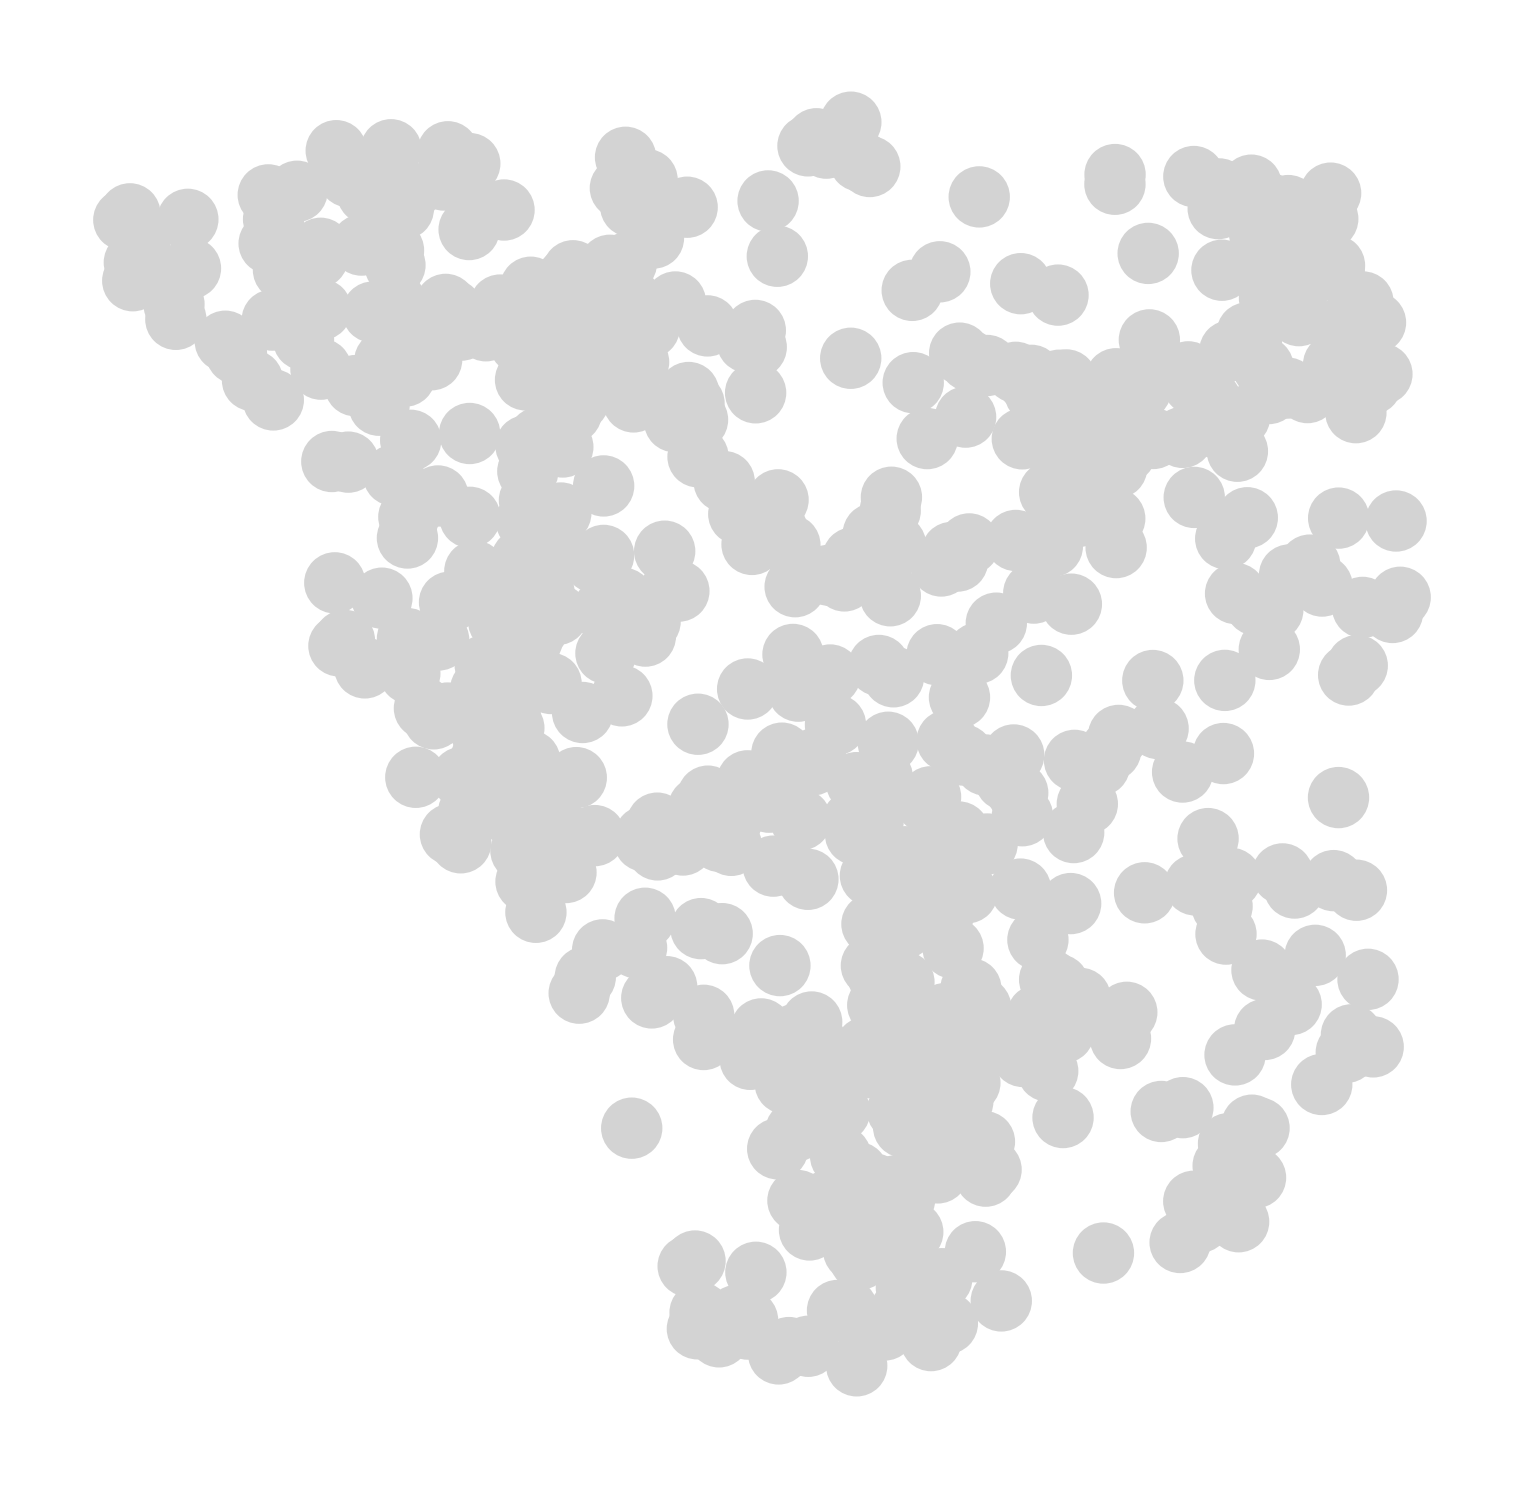

In [99]:
sc.pl.draw_graph(adata, legend_loc="on data")

In [100]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=5, use_rep="X_diffmap")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98963207 0.98905784 0.98278034 0.97316843 0.9711131
     0.9705649  0.9637664  0.9619089  0.9611139  0.95952946 0.9532425
     0.9470375  0.9424452  0.9411893 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


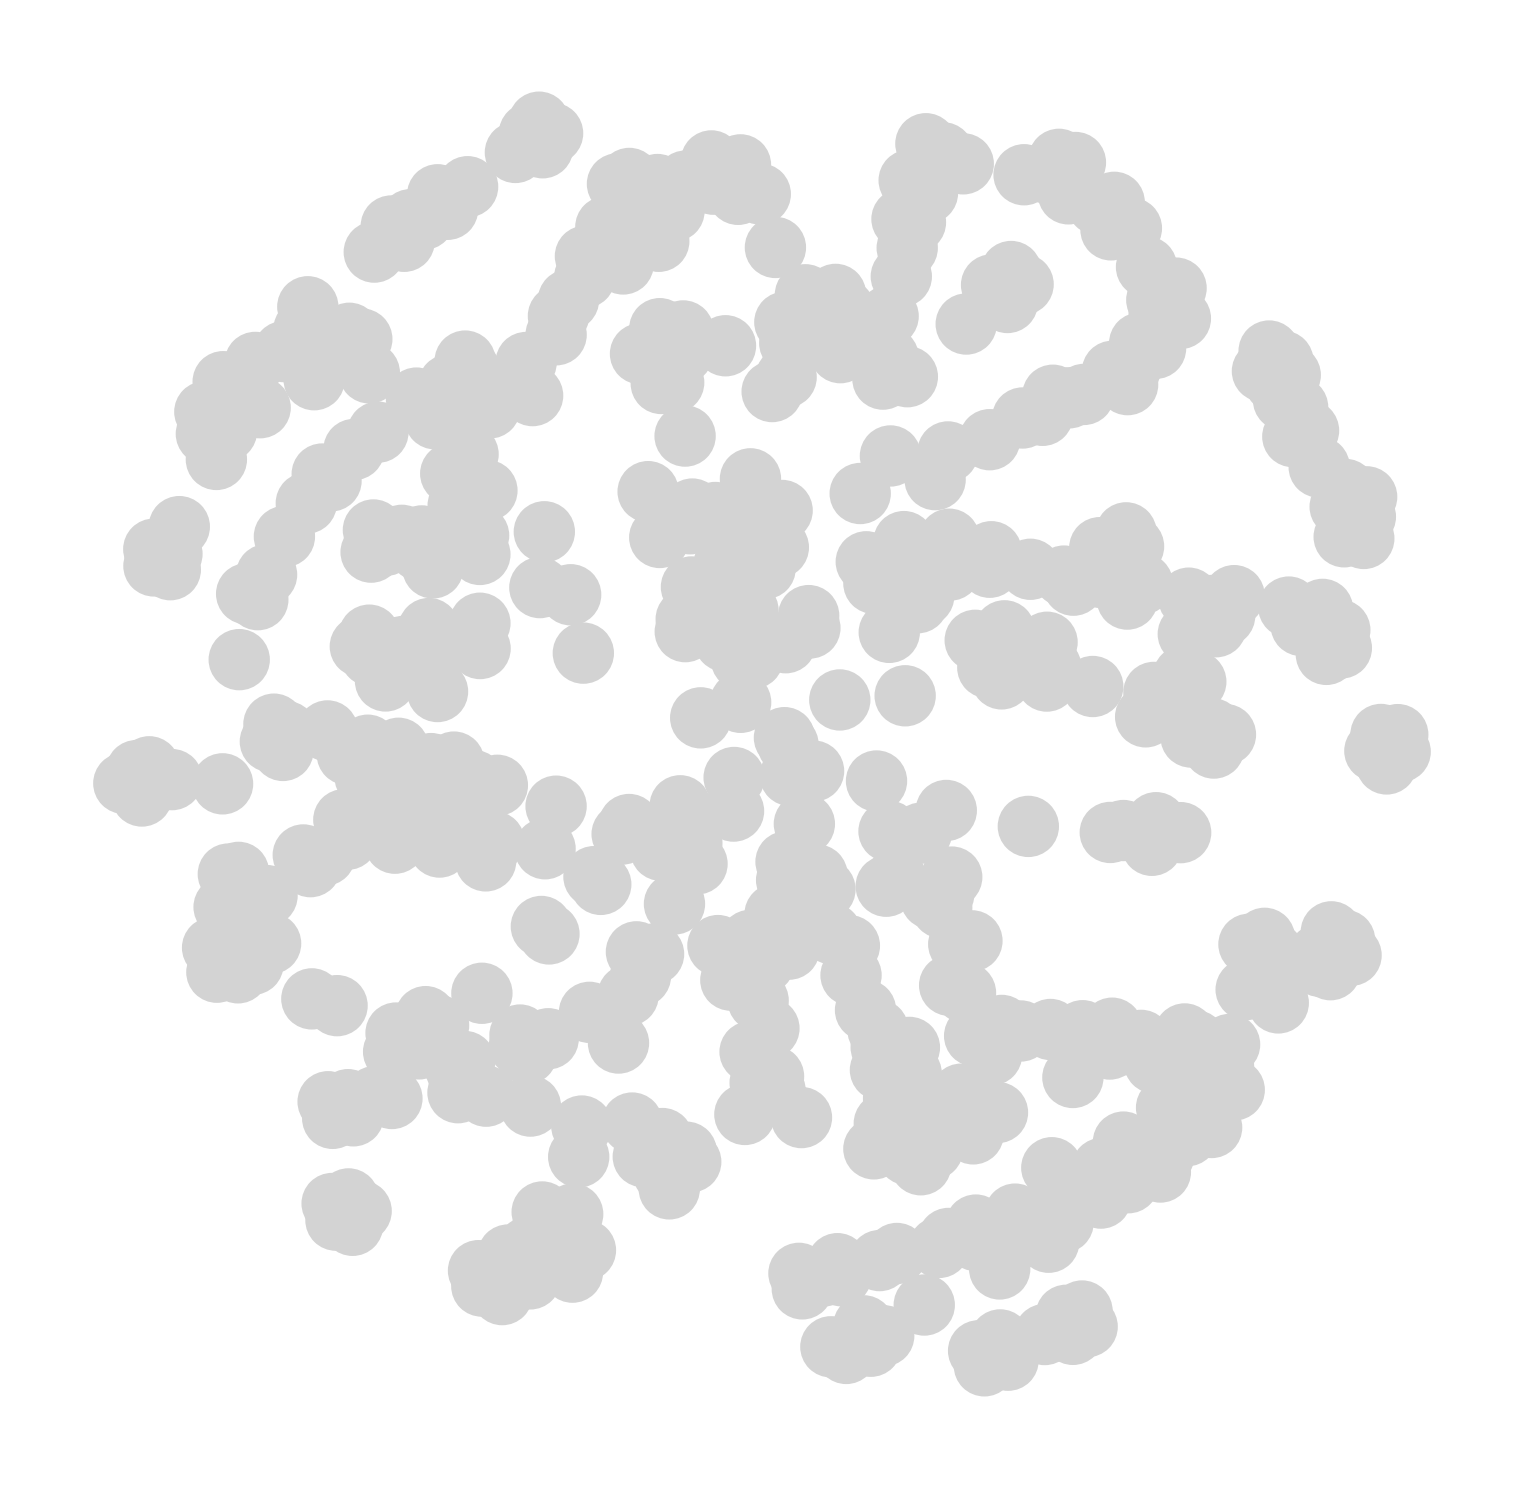

In [101]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, legend_loc="on data")

In [102]:
sc.tl.leiden(adata, resolution=2)

running Leiden clustering
    finished: found 44 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [80]:
sc.tl.paga(adata, groups="leiden")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


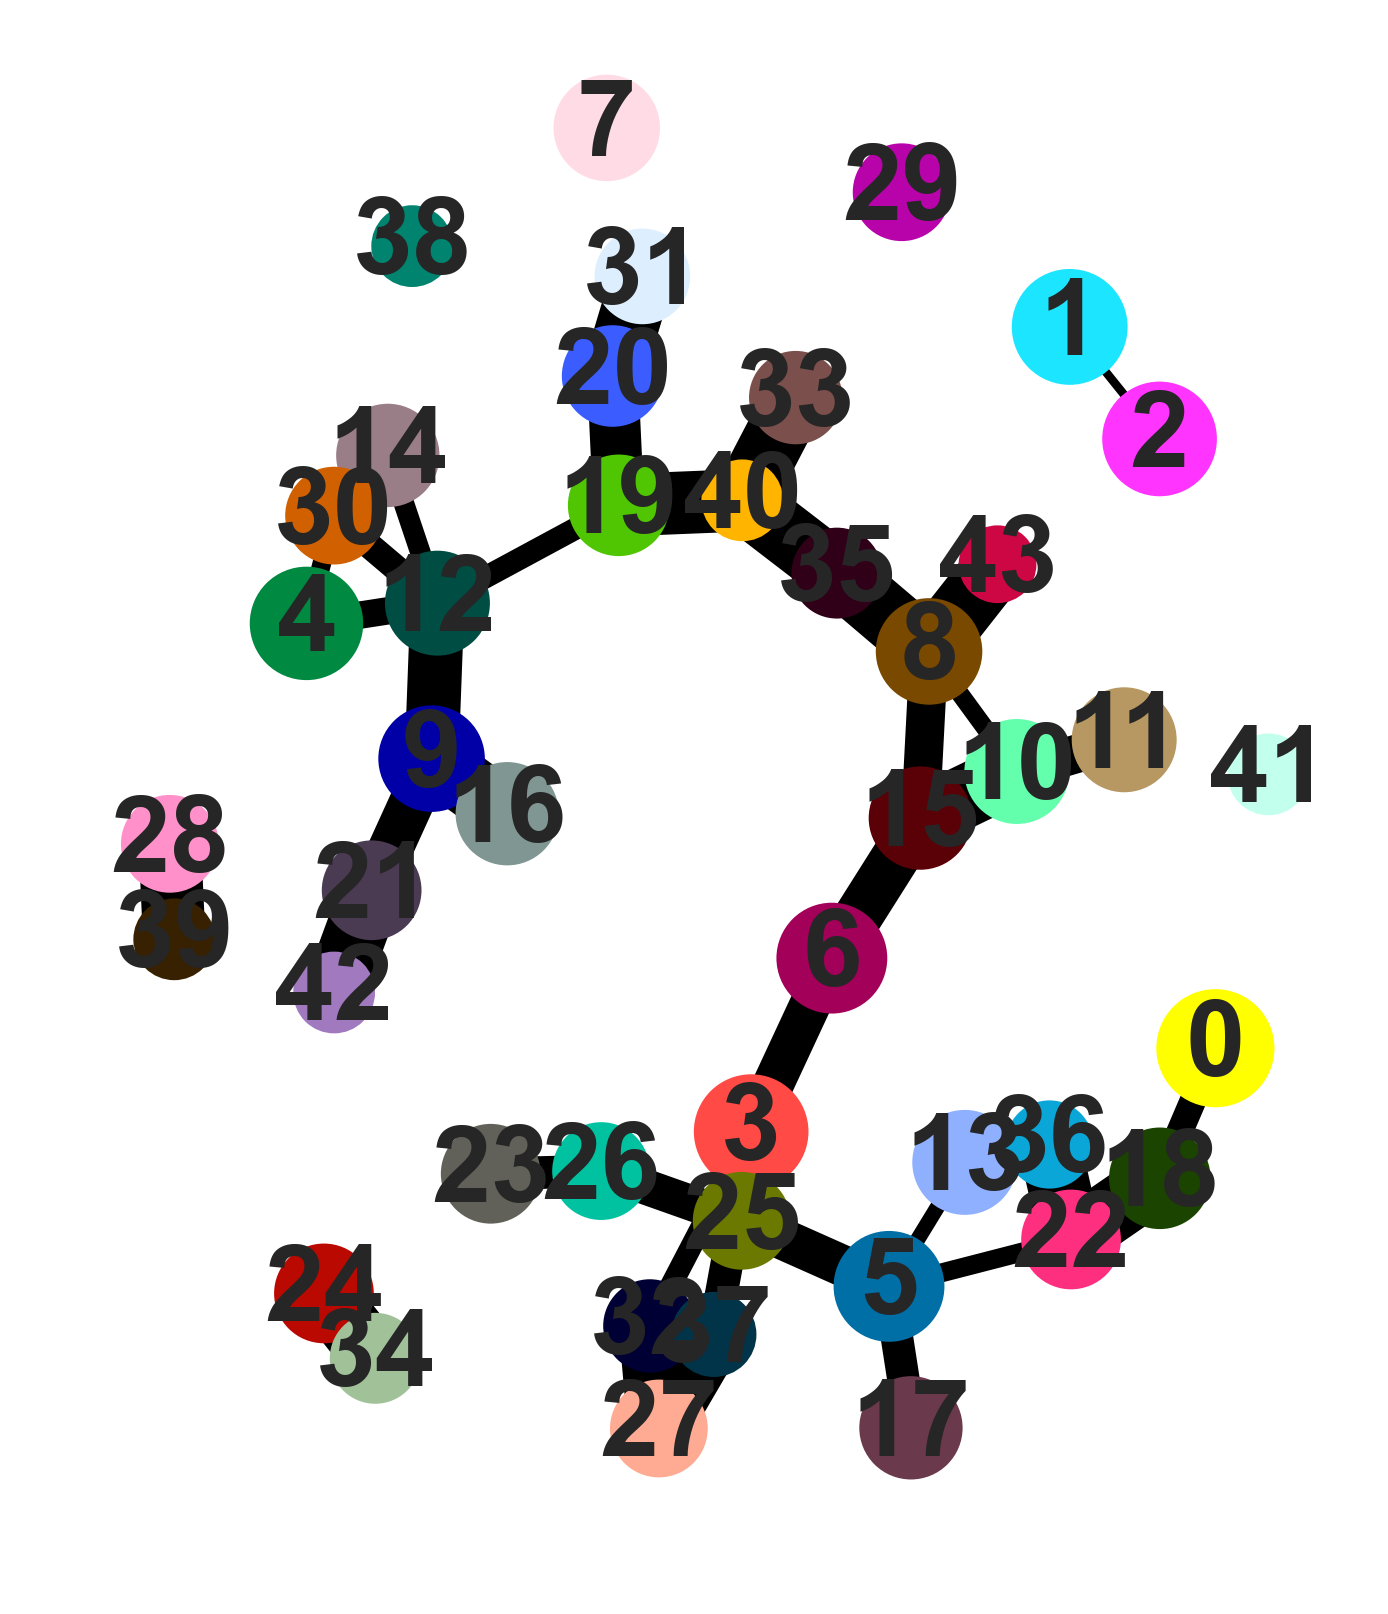

In [81]:
sc.pl.paga(adata, color=["leiden"])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


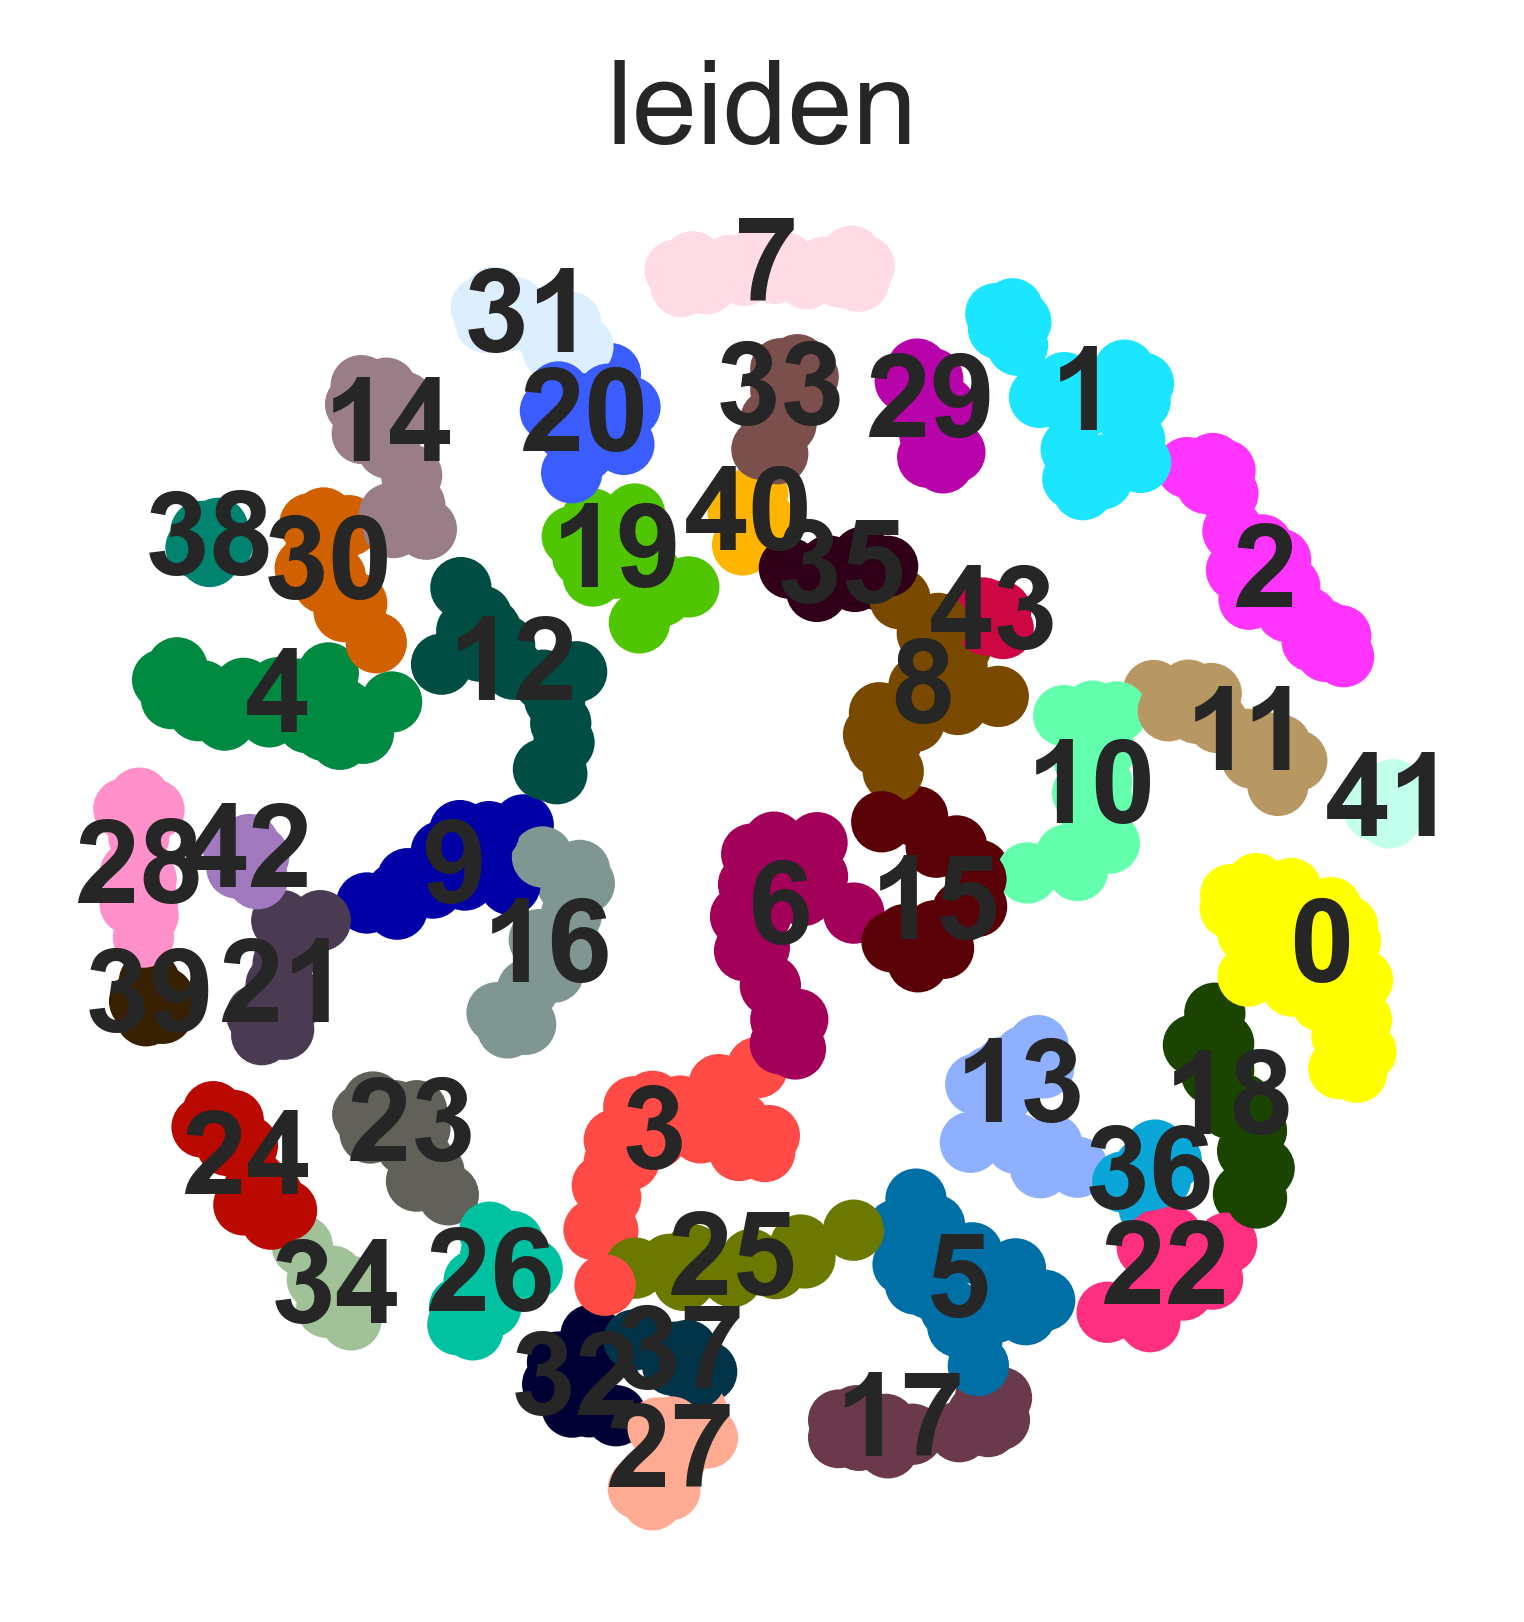

In [82]:
sc.tl.draw_graph(adata, init_pos="paga")
sc.pl.draw_graph(
    adata, color=["leiden"], legend_loc="on data"
)

In [89]:
for gene in adata.obs[adata.obs['leiden'] == "13"].index:

    print(gene)

RNASE4
HSP90AA1
SORD
CALR
KRT75
YWHAZ
LTF
YWHAQ
ASS1
PRSS2
LDHB
TNXA
F7
MMRN1
PSME1


In [17]:
filtered_df = feature_clusters_df.loc[
    feature_clusters_df.groupby("FeatureCluster")['CorrectedPValue2-1'].idxmin()
].copy()

In [18]:
qm_filtered = (

    QuantMatrix(
        quantification_file=filtered_df,
        design_matrix_file=design_matrix
    )

)

In [19]:
import xgboost

clf = xgboost.XGBClassifier(
    max_depth=2,
    #subsample=0.5,
    reg_lambda=2,
    objective="binary:logistic",
    seed=42
)

#
qm_filtered = qm_filtered.explain(
    clf,
    comparisons=[(2, 1)],
    n_iterations=10,
    downsample_background=True
)

ModuleNotFoundError: No module named 'xgboost'

In [27]:
qm_filtered.row_annotations.sort_values("MeanImportance2-1", ascending=False).head(10)

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster,MeanImportance2-1,MeanRank2-1
125,P06727,APOA4,0.823301,25.442027,24.360986,0.911909,1.122310,1.081041,5.675327e-12,123,74,5.046987e-11,10.296968,126,0.893472,1.6
124,P59665,DEFA1,1.298690,22.938065,21.490092,0.951574,0.842042,1.447973,1.988787e-21,123,74,4.952078e-19,18.305212,125,0.487850,3.3
23,P05362,ICAM1,1.357118,19.934267,18.281489,1.240808,0.655209,1.652779,7.118802e-21,123,74,5.908606e-19,18.228515,24,0.421628,3.4
3,Q96PD5,PGLYRP2,0.744918,21.714376,22.507637,0.708453,0.671858,-0.793261,5.933360e-13,123,74,5.909626e-12,11.228440,4,0.396599,5.8
128,P61769,B2M,1.076449,22.823686,21.643795,0.733103,0.974937,1.179891,4.413086e-18,123,74,1.373573e-16,15.862148,129,0.231229,10.3
2,P35858,IGFALS,0.491625,20.317330,21.028709,1.109570,0.717600,-0.711379,1.968163e-06,123,74,4.989151e-06,5.301973,3,0.156810,11.9
18,P18428,LBP,0.500513,23.456669,22.751223,0.966166,0.874544,0.705445,7.497413e-07,123,74,2.029191e-06,5.692677,19,0.118190,9.8
126,P12109,COL6A1,0.916792,18.838322,17.917189,0.720126,0.655965,0.921133,2.964058e-16,123,74,6.150421e-15,14.211095,127,0.109106,18.2
67,P19320,VCAM1,1.083607,19.122258,18.155677,0.588427,0.711141,0.966581,5.133936e-20,123,74,2.556700e-18,17.592320,68,0.084701,12.0
121,P07858,CTSB,0.827379,19.824832,18.902631,0.859933,0.595698,0.922201,6.435766e-14,123,74,8.902810e-13,12.050473,122,0.070882,21.7


<Axes: xlabel='MeanImportance2-1', ylabel='Gene'>

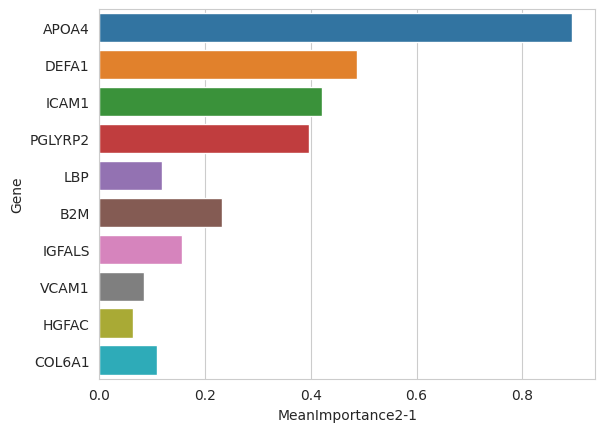

In [28]:
sns.barplot(
    data=qm_filtered.row_annotations.sort_values("MeanRank2-1", ascending=True).head(10),
    x="MeanImportance2-1",
    y="Gene"
)

In [29]:
selected_clusters = qm_filtered.row_annotations.sort_values("MeanRank2-1", ascending=True).head(10)['FeatureCluster'].values

In [30]:
qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
8,P02787,TF,0.114378,29.080894,29.235061,0.498493,0.448078,-0.154166,3.112043e-02,123,74,2.483154e-02,1.604996,1
9,P00738,HP,0.069402,30.383598,30.264077,1.583586,1.104578,0.119521,5.705962e-01,123,74,2.847264e-01,0.545572,1
16,P01833,PIGR,0.683225,21.296659,20.228673,1.555793,1.044303,1.067986,4.758315e-07,123,74,1.331259e-06,5.875738,68
19,P19823,ITIH2,0.647102,24.466525,25.121607,0.686775,0.470310,-0.655082,1.204775e-11,123,74,9.999634e-11,10.000016,4
20,P02647,APOA1,0.496280,28.098708,28.711876,0.802006,0.601049,-0.613169,5.428636e-08,123,74,1.931043e-07,6.714208,4
24,P01034,CST3,0.596771,20.999049,20.294765,0.625732,0.889936,0.704285,7.744293e-10,123,74,4.102828e-09,8.386917,129
31,P02750,LRG1,0.294239,25.726686,25.326911,0.711183,0.676590,0.399775,1.477257e-04,123,74,2.452247e-04,3.610436,19
35,P61626,LYZ,0.768608,21.052191,20.225375,0.666539,0.784903,0.826816,2.890111e-13,123,74,3.271080e-12,11.485309,129
39,Q04756,HGFAC,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,5.847756e-06,5.233011,1
40,P02768,ALB,0.024260,32.911592,32.883534,0.230820,0.241586,0.028058,4.202495e-01,123,74,2.221701e-01,0.653314,1


In [31]:
for gene in qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]['Gene']:

    print(gene)

TF
HP
PIGR
ITIH2
APOA1
CST3
LRG1
LYZ
HGFAC
ALB
APOA4
AFM
LGALS3BP
ITIH1
ICAM1
TGFBI
AHSG
SERPINF1
NID1
FCN3
CD163
CD14
CD44
APOL1
RNASE1
B2M
C1RL
B4GALT1
VCAM1
CLEC3B
DEFA1
CD59
COL6A1
PVR
PLTP
SERPINA10
BCHE
TFRC
MGP
GPLD1
PGLYRP2
GLUD1
CRP
LILRA3
PON3
IGFALS
DBH
PON1
MAN1A1
MMP8
LCN2
CFD
LBP
FCGR3A


In [32]:
qm.sample_annotations['group'].unique()

array([2, 1])

In [33]:
qm.row_annotations.shape

(554, 14)

In [34]:
filtered_df = qm_filtered.to_df()

In [35]:
small_qm = QuantMatrix(
    quantification_file=filtered_df[filtered_df['Gene'].isin(qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]['Gene'])],
    design_matrix_file=design_matrix
)

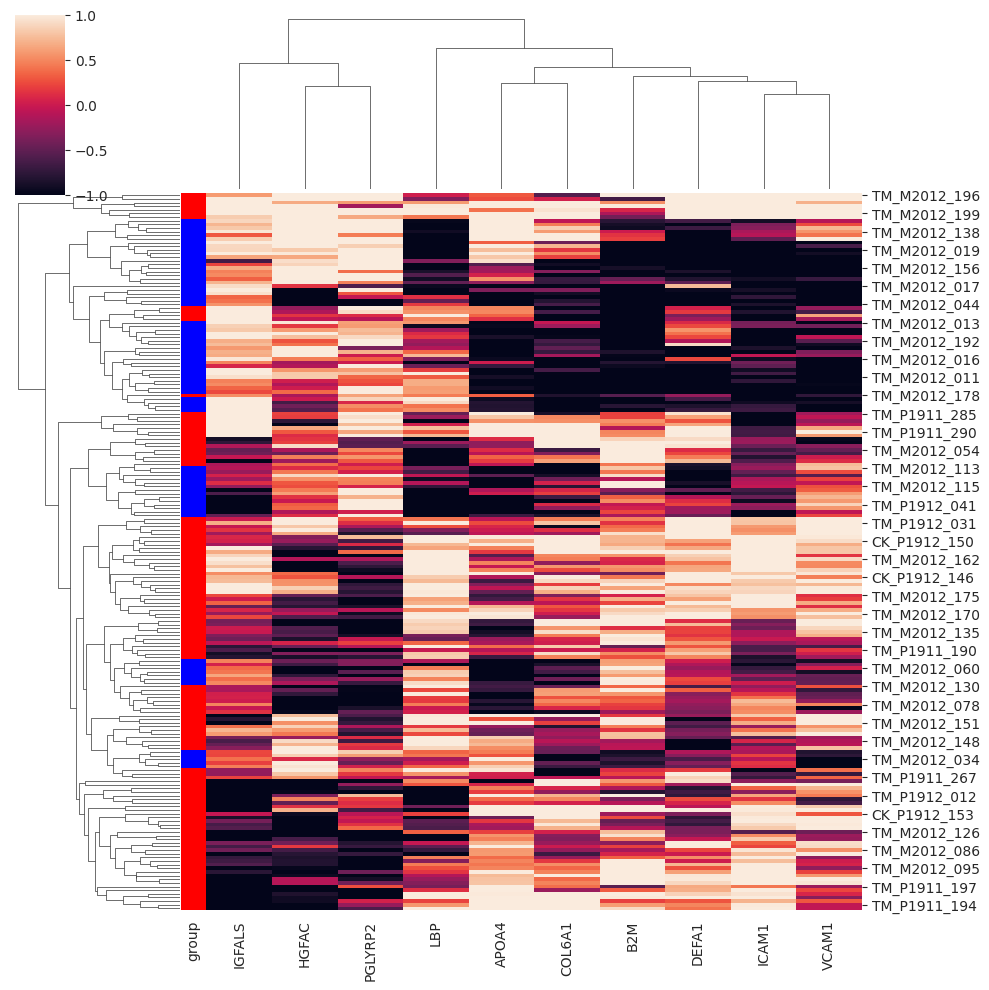

In [36]:
lut = dict(zip(small_qm.sample_annotations['group'].unique(), "rbg"))
row_colors = small_qm.sample_annotations['group'].map(lut)
sns.clustermap(
    small_qm.to_ml(feature_column="Gene")[0],
    row_colors=row_colors,
    z_score=1,
    vmin=-1,
    vmax=1,
)

In [37]:
qm_filtered.row_annotations.shape

(130, 16)

/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


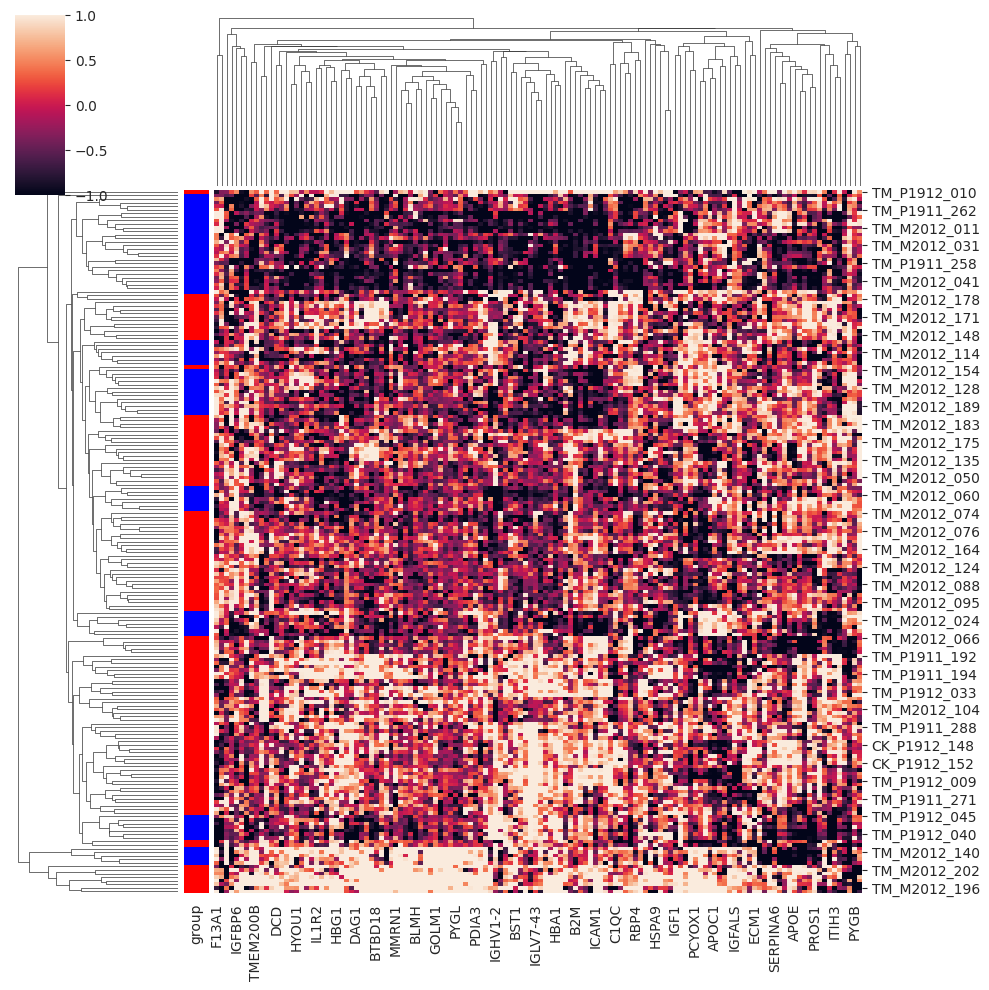

In [38]:
lut = dict(zip(qm_filtered.sample_annotations['group'].unique(), "rbg"))
row_colors = qm_filtered.sample_annotations['group'].map(lut)
sns.clustermap(
    qm_filtered.to_ml(feature_column="Gene")[0],
    row_colors=row_colors,
    z_score=1,
    vmin=-1,
    vmax=1,
)